# Trajectory dataset preparation

This notebook contains some data-wrangling codes. The goal is to extract from the dataset, trajectories under suitable forms to perform FPCA and distribution learning.

# Preambles

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
# sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

%matplotlib inline

# Load data from Pickled file

To restore variables, run this code:

In [2]:
import pickle

with open('prepare_trajectories.pkl', 'rb') as handle:
    pkl_obj = pickle.load(handle)
    container_t_np = pkl_obj['t']
    container_x_np = pkl_obj['x']
    container_y_np = pkl_obj['y']
    print('Data loaded from file')

num_of_trajs = container_y_np.shape[0]

Data loaded from file


# Global FPCA decomposition for Y component

In [3]:
import sklearn
import skfda

%matplotlib inline

Convert the data to appropriate type for the skfda package

In [4]:
fdgrx = skfda.FDataGrid(container_x_np, np.arange(container_x_np.shape[1]))
fdgry = skfda.FDataGrid(container_y_np, np.arange(container_y_np.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [5]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

Text(0.5, 1.0, 'Direct KLT basis')

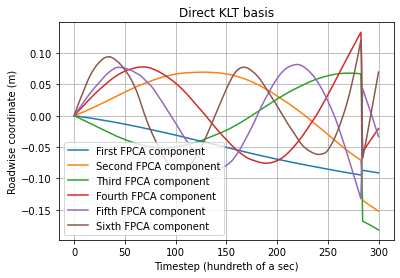

In [6]:
fpca_y = FPCA(n_components=6)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')
plt.title('Direct KLT basis')

In [24]:
ycov = fdgry.cov().data_matrix
ycov = np.reshape(ycov, ycov.shape[1:3])

In [25]:
_, klt_basis = np.linalg.eig(ycov)
klt_basis = np.real(klt_basis[:270,:].T)

We will also get the AFRAID Transform, generated from the afraid_transform.ipynb file, to compare M-terms approximation performance between Karhunen-Loeve Transform and AFRAID Transform:

In [26]:
import pickle
with open('afraid_270.basis', 'rb') as f:
    afraid_transform = pickle.load(f)

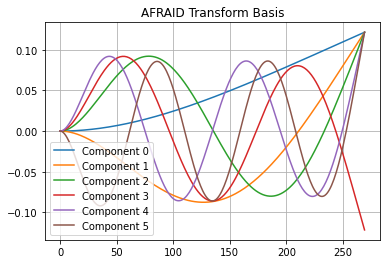

In [27]:
for i in range(6):
    plt.plot(afraid_transform[:,i], label='Component {:d}'.format(i))
plt.grid()
plt.legend()
plt.title('AFRAID Transform Basis')
afraid_basis = afraid_transform.T 

Let's approximate the average error when representing 100 trajectories in each basis: KLT and OCT

In [39]:
chosen_trajs = np.random.choice(num_of_trajs, size=100)
test_set = container_y_np[chosen_trajs,:270] - (fpca_y.mean_.data_matrix.reshape(-1))[:270]
klt_scores = test_set @ klt_basis.T
afraid_scores = test_set @ afraid_basis.T 

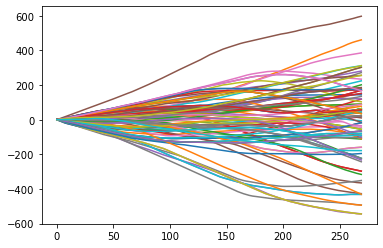

In [40]:
for i in range(test_set.shape[0]):
    plt.plot(test_set[i,:])

First we should check to make sure that the signal energy is well preserved in both basis.

In [44]:
signal_energy = np.sum(np.square(test_set), axis=1)
print('Max difference between KLT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(klt_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between OCT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(afraid_scores), axis=1) - np.sum(np.square(test_set), axis=1))))

Max difference between KLT coeffs energy and signal energy: 12340.98249990493
Max difference between OCT coeffs energy and signal energy: 685382.8427604809


Next, we try to compare the average approximation error with 1, 2, 3, ... components allowed to represent.

In [60]:
representation_error_of_klt = np.ones((100, 10))
representation_error_of_oct = np.ones((100, 10))
representation_error_of_klt_avg = np.ones((10,))
representation_error_of_oct_avg = np.ones((10,))
for max_components_allowed in range(1,10):
    tail_of_signal_klt = test_set - klt_scores[:,:max_components_allowed] @ klt_basis[:max_components_allowed,:]
    energy_of_signal_tail_klt = np.sum(np.square(tail_of_signal_klt), axis=1)
    proportion_of_energy_klt = energy_of_signal_tail_klt / signal_energy
    representation_error_of_klt[:,max_components_allowed] = proportion_of_energy_klt
    representation_error_of_klt_avg[max_components_allowed] = np.average(proportion_of_energy_klt)
    # Choose 10 trajectories 

    tail_of_signal_oct = test_set - afraid_scores[:,:max_components_allowed] @ afraid_basis[:max_components_allowed,:]
    energy_of_signal_tail_oct = np.sum(np.square(tail_of_signal_oct), axis=1)
    proportion_of_energy_oct = energy_of_signal_tail_oct / signal_energy
    representation_error_of_oct[:,max_components_allowed] = proportion_of_energy_oct
    representation_error_of_oct_avg[max_components_allowed] = np.average(proportion_of_energy_oct)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'M-terms approximation performance\nAveraged over 100 trajectories')

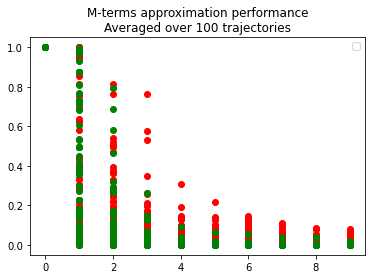

In [61]:
for i in range(10):
    plt.scatter(i*np.ones((representation_error_of_klt.shape[0],)), representation_error_of_klt[:,i], c='r')
    plt.scatter(i*np.ones((representation_error_of_oct.shape[0],)), representation_error_of_oct[:,i], c='g')
plt.legend()
plt.title('M-terms approximation performance\nAveraged over 100 trajectories')

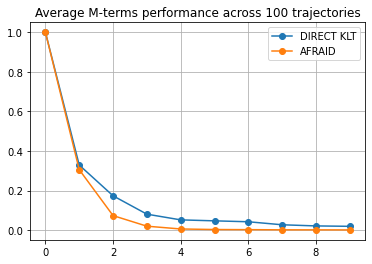

In [64]:
plt.plot(representation_error_of_klt_avg, '-o', label='DIRECT KLT')
plt.plot(representation_error_of_oct_avg, '-o', label='AFRAID')
plt.title('Average M-terms performance across 100 trajectories')
plt.legend()
plt.grid()